## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [14]:
#!pip install -r requirements.txt

In [15]:
import pandas as pd
import cfe.regression as rgsn

### Data



We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.

Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [16]:
InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

#### Prices, FCT, RDI



In [17]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

# Get prices
p = read_sheets(InputFiles['Prices'][0],
                sheet=InputFiles['Prices'][1])

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = read_sheets(InputFiles['FCT'][0],
                  sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = read_sheets(InputFiles['RDI'][0],
                  sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [28]:
r = rgsn.read_pickle('../Project3/uganda_estimates.rgsn')  # Assumes you've already set this up e.g., in Project 3

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [29]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2019-20',level='t').mean()
pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

#### Budgets



Get food budget for all households, then find median budget:



In [30]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [31]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Beans,Beef,Biscuits,Bread,Cabbages,Cassava,Chapati,Cooking Oil,Dodo,Eggs,...,Rice,Salt,Sim Sim,Soda,Sorghum,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.944832,0.936354,0.477258,0.817356,0.532138,7.140475,1.352763,0.913778,2.221014,1.316439,...,2.090228,0.208455,0.212272,0.975857,1.378828,1.747461,10.554325,0.020702,2.190336,0.709079
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,0.601683,0.664828,0.226197,0.517056,0.346857,4.347518,0.937521,0.589507,1.231264,1.143533,...,1.053881,0.157112,0.165295,0.737203,0.734268,1.496446,4.855473,0.013235,1.655719,1.150022
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.705483,0.656232,0.121730,0.466247,0.330787,5.152482,0.844902,0.577157,1.302743,1.041940,...,1.015437,0.167272,0.127358,0.527319,0.704993,1.073658,5.404692,0.012808,1.530113,0.910277
1013000201,2019-20,Central,1.077262,1.595333,0.965305,1.606522,0.608797,3.029232,2.415013,0.813083,2.638925,1.944924,...,1.747160,0.147278,0.249697,2.148505,1.305082,3.071233,5.265512,0.033181,3.192322,1.085805
1013000202,2019-20,Central,0.800843,0.664074,0.150986,0.416544,0.266464,3.131315,0.617087,0.391193,1.243471,1.042583,...,0.674651,0.166953,0.072092,0.383314,0.300997,0.983184,3.297976,0.012904,1.144660,0.585482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,1.289085,1.080040,0.510802,0.724511,0.489217,9.392604,1.501268,0.759374,2.315477,1.612950,...,2.392065,0.260287,0.241644,1.015902,1.389384,3.526140,14.308265,0.017080,1.926127,2.167975
c33f6cb57d9849949e08a7350dabb829,2019-20,Central,0.706218,0.906975,0.340750,0.651723,0.355474,2.504848,1.037414,0.466634,1.612259,1.227569,...,0.860024,0.121381,0.117856,0.984016,0.522995,1.396215,3.412185,0.018921,1.665314,0.635675
d10a687889de469687377204195f3db0,2019-20,Western,1.127324,0.778021,0.239983,0.426281,0.342863,4.323621,0.643660,0.491754,1.069632,1.145352,...,0.601588,0.234382,0.246366,0.546301,1.089402,1.371290,2.695450,0.019307,1.610666,0.776612


Finally, define a function to change a single price in the vector $p$:



In [32]:
def my_prices(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



Text(0.5, 0, 'Quantities of Millet Demanded')

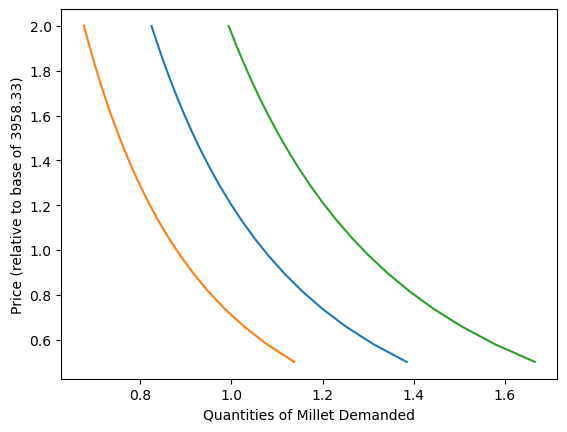

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Millet'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



Text(0.5, 1.0, 'Engel Curves')

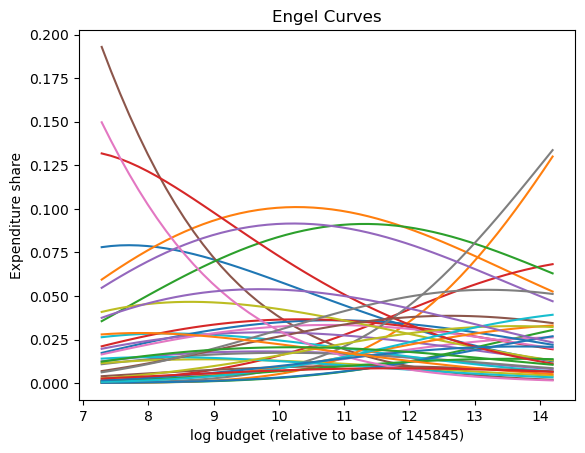

In [35]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [36]:
fct

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomatoes,180,9.0,10.0,150,100,39.0,3.0,5.94,0.19,0.37,420,0.0,0.80,127,2.0
Waragi,2630,0.0,0.0,0,0,0.0,0.0,0.00,0.00,0.00,0,0.0,0.00,0,0.0
Watermelon,300,6.1,4.0,30,70,75.5,2.4,1.78,0.21,0.33,280,0.0,0.45,81,1.0


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [37]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Beef', 'Biscuits', 'Bread', 'Cabbages', 'Chapati', 'Cooking Oil',
       'Dodo', 'Eggs', 'Mangos', 'Millet', 'Onions', 'Oranges', 'Peas', 'Pork',
       'Sim Sim', 'Soda', 'Sorghum', 'Sweet Bananas', 'Tomatoes', 'Waragi'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [38]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,00c9353d8ebe42faabf5919b81d7fae7,0d0e29faff394154a69562b4527b48b8,0e03e253c35d4333a1ffad2df9d38850,1013000201,1013000202,1013000204,1021000108,1021000109,1021000111,1021000506,...,a98bebba177243668464e31f6d2bb92d,ab5cbcbe0e14402aae73b91c6917a595,acb16f9b068549d8a80a37c9d638742f,ad9b7c4ba614444bb8004eb658693c9f,bfd8253bd59c4f3199fb4b83b9cee7a6,bfdf0d66403440ceab439b1e1c47cdea,c33f6cb57d9849949e08a7350dabb829,d10a687889de469687377204195f3db0,d24fa50d02c041969a42102d8ebdadc9,e07bc322c4884559b4b8ca75c945dd3e
t,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,...,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20
m,Eastern,Eastern,Eastern,Central,Central,Central,Central,Central,Central,Central,...,Western,Eastern,Western,Eastern,Eastern,Eastern,Central,Western,Eastern,Northern
n,,,,,,,,,,,,,,,,,,,,,
Energy,40565.169487,28860.668623,25914.599391,54642.302909,19824.936040,69683.944662,24005.755413,54544.141666,43022.231250,35389.901757,...,100508.540075,37764.720664,44910.693535,86401.198587,72469.008615,48548.295849,27355.009055,28571.904787,59909.406125,47820.784531
Protein,1090.655045,781.748134,735.935591,1713.772744,657.899351,2121.466088,779.220391,1709.580188,1282.980271,1104.385265,...,2937.298787,1017.946600,1307.735487,2477.545602,2050.310938,1251.412515,895.473023,874.897464,1611.961824,1399.042700
Fiber,525.157057,345.750200,305.894484,626.182340,220.973361,779.495989,273.597885,612.694549,470.878695,401.859283,...,1494.917561,466.133259,590.603141,1295.009358,928.541677,656.471518,307.997099,371.969956,761.467555,665.230252
Folate,9143.616723,5767.724243,5312.587652,11904.750778,4633.935201,13903.617800,5461.501500,11549.130179,8504.307519,7489.615531,...,18399.380115,7431.060413,8305.823921,19961.122903,14634.112865,10492.642671,6158.387271,5714.455998,12240.342108,9244.633956
Calcium,13954.787513,8925.901261,8226.906160,18268.624523,6777.377359,22263.925410,8220.447097,16861.296566,13491.326441,11315.999561,...,27873.991254,11551.755326,12999.951948,31977.311191,23372.624355,15484.337813,9433.643255,8826.327173,19206.833762,13582.576522
Carbohydrate,5333.706682,3419.876661,2989.788735,7200.566117,2166.831526,9218.147524,2702.571296,6681.177247,5072.548772,4039.979842,...,15004.430486,4788.889836,5705.729502,12874.602676,9699.819665,6392.799882,3297.401406,3502.253174,7954.682896,6867.890378
Iron,304.579216,196.466090,182.044707,417.343056,147.724064,509.837441,179.174775,395.984572,306.450226,255.029205,...,847.039778,266.188611,341.618363,689.511369,549.905624,329.301816,208.475200,227.611601,437.889294,386.053655


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [39]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

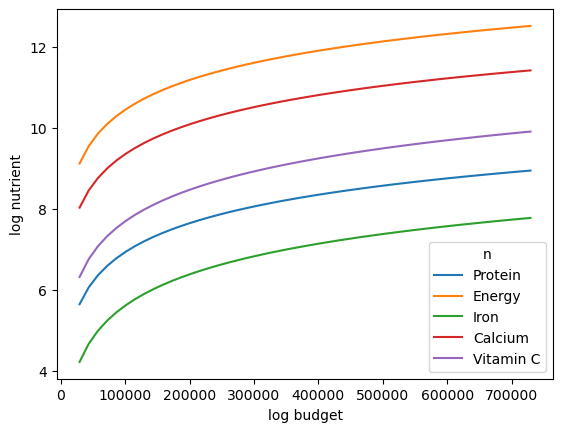

In [40]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



Text(0, 0.5, 'log nutrient')

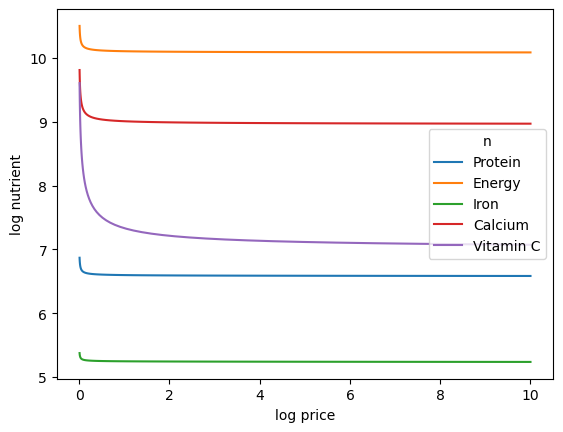

In [41]:
USE_GOOD = 'Oranges'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [42]:
# In first round, averaged over households and villages
dbar = r.d[rdi.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [43]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi@dbar

hh_rdi

n
Energy           9302.189239
Protein           207.761410
Fiber             130.230649
Folate           1742.820037
Calcium          5693.803340
Carbohydrate      692.063080
Iron               56.743228
Magnesium        1492.808905
Niacin             66.481633
Phosphorus       4292.437848
Potassium       23178.552876
Riboflavin          5.208200
Thiamin             5.059369
Vitamin A        3472.912801
Vitamin B-12       10.456920
Vitamin B-6         5.785158
Vitamin C         312.990724
Vitamin E          64.935436
Vitamin K         414.634508
Zinc               42.189610
dtype: float64